# **Modeling Test #4**
### 장르별로 분류된 줄거리 Clustering w/ KoBART

<br><br><hr>

## **✅ 00. 기본 설정**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 메시지 출력 X
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 한글 font 설정
import platform
import matplotlib.font_manager as fm

#matplotlib 패키지 한글 깨짐 처리 시작
#------------------------------------------------------------------------------------
# 운영체제별 한글 폰트 설정

if platform.system() == 'Darwin': # Mac 환경 폰트 설정
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows 환경 폰트 설정
    plt.rc('font', family='Malgun Gothic')
    
plt.rcParams['axes.unicode_minus'] = False #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [3]:
# 글씨 선명하게 출력하는 설정

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

<br><br><br><hr>

## **✅ 01. 데이터 불러오기**

In [4]:
movies = pd.read_csv('..\data\movies_4000_tmdb_genre.csv')
print(movies.shape)   # (4241, 6)
movies.head(3)

(4241, 6)


,asset_nm_전처리,ct_cl,genre_of_ct_cl,summary_최신순,최신순,genre_tmdb
0,귀멸의 칼날: 남매의 연,영화,애니메이션,혈귀의 습격으로 가족을 잃은 소년 ‘탄지로’. 유일하게 살아남은 여동생 ‘네즈코’마...,2019-03-29,"Animation, Action, Fantasy, Thriller"
1,색에 놀다,영화,에로틱,하얀 색의 순수하고 착한 사랑을 꿈꾸는 25살 모태 솔로 지수. 그녀의 짝사랑 상대...,2017-01-01,"Thriller, Drama, Romance"
2,돌이킬 수 없는 주말,영화,공포/스릴러,베키는 결혼을 앞두고 친구 수잔과 함께 다트무어로 여행을 떠난다. 그곳에서 신비한 ...,2015-09-18,"Drama, Horror, Mystery"


<br>

#### *>> 장르가 '성인' 또는 '기타'인 행와 장르의 value_counts가 40개 미만인 행은 삭제*

In [5]:
# 각 장르의 수 를 genre_counts 변수에 저장
genre_counts = movies['genre_of_ct_cl'].value_counts()

In [6]:
# 삭제할 조건 생성
delete_conditions = (movies['genre_of_ct_cl'] == '성인') | (movies['genre_of_ct_cl'] == '기타') | (movies['genre_of_ct_cl'].isin(genre_counts[genre_counts < 40].index))
filtered_movies = movies[~delete_conditions]

In [7]:
# 결과 확인
print(filtered_movies.shape)
filtered_movies['genre_of_ct_cl'].value_counts()

### (4241, 6) >> (3675, 6) >> 566개의 행 삭제

(3675, 6)


genre_of_ct_cl
드라마        1011
액션/어드벤쳐     977
공포/스릴러      639
멜로          329
코미디         265
애니메이션       169
SF/환타지      159
다큐멘터리       126
Name: count, dtype: int64

<br>

#### *>> 사용하지 않을 열 drop*

In [8]:
col_to_drop = ['ct_cl', '최신순', 'genre_tmdb']
drop_movies = filtered_movies.drop(columns=col_to_drop, axis=1)

drop_movies.head(3)

,asset_nm_전처리,genre_of_ct_cl,summary_최신순
0,귀멸의 칼날: 남매의 연,애니메이션,혈귀의 습격으로 가족을 잃은 소년 ‘탄지로’. 유일하게 살아남은 여동생 ‘네즈코’마...
2,돌이킬 수 없는 주말,공포/스릴러,베키는 결혼을 앞두고 친구 수잔과 함께 다트무어로 여행을 떠난다. 그곳에서 신비한 ...
3,섹스 앤 머니,액션/어드벤쳐,갱단 두목 페페는 라이벌 갱단 두목 조조와 세력 다툼을 벌이다 쫓기는 신세가 된다....


<br><br><br><hr>

## **✅02. 특수문자/숫자 제거 및 불용어 가져오기**

In [9]:
import re

In [10]:
# 정규표현식을 이용해 숫자를 공백으로 변경 (정규 표현식으로 \d는 숫자 의미)
drop_movies['summary_최신순'] = drop_movies['summary_최신순'].apply(lambda x : re.sub(r"\d+", "", x))

In [11]:
# 정규표현식을 이용해 특수문자를 공백으로 변경
drop_movies['summary_최신순'] = drop_movies['summary_최신순'].apply(lambda x: re.sub(r"[^가-힣a-zA-Z0-9\s]", "", x))

In [12]:
# stopwords 가져오기
with open('..\data\stopwords\combined_stopwords.txt', 'r', encoding='utf-8') as stopwords_file:
    custom_stopwords = stopwords_file.read().splitlines()

<br><br><br><hr>

## **✅ 03. 장르별 데이터프레임 생성**

In [13]:
drama = drop_movies[drop_movies['genre_of_ct_cl']=='드라마']
print(drama.shape)

# 인덱스 정렬
# 데이터 인덱스 재설정
drama = drama.reset_index(drop=True)
drama.head(3)

(1011, 3)


,asset_nm_전처리,genre_of_ct_cl,summary_최신순
0,서울의 봄,드라마,박 대통령의 암살 이후 계엄령이 선포된다 국군보안사령관 전두광과 그를 따르는 장교들...
1,연평해전,드라마,월드컵의 열기로 뜨거웠던 년 월 해군 출신 아버지의 자랑스러운 아들이자 참수리 호 ...
2,몽상가들,드라마,자유를 외치는 젊은이들의 뜨거운 열기로 가득한 년 파리 영화광인 미국인 유학생 매튜...


<br><br><br><hr>

## **✅ 04. 줄거리 clustering**

In [16]:
from transformers import BartModel
from kobart import get_pytorch_kobart_model, get_kobart_tokenizer

In [17]:
# KoBART 모델과 토크나이저 불러오기
kobart_tokenizer = get_kobart_tokenizer()
kobart_model = BartModel.from_pretrained(get_pytorch_kobart_model())

using cached model. c:\workspaces\10_proj\model-test\model_test\.cache\kobart_base_tokenizer_cased_cf74400bce.zip


You passed along `num_labels=3` with an incompatible id to label map: {'0': 'NEGATIVE', '1': 'POSITIVE'}. The number of labels wil be overwritten to 2.


using cached model. c:\workspaces\10_proj\model-test\model_test\.cache\kobart_base_cased_ff4bda5738.zip


<br><br><br><hr>

## **✅ 05. VOD 줄거리 벡터화**

In [18]:
import sys
import ipywidgets

In [19]:
# 특수문자가 잘 제거되었는지 확인
drama[drama['summary_최신순'].str.contains(r'\.', na=False)]

,asset_nm_전처리,genre_of_ct_cl,summary_최신순


In [20]:
# 1. test 문장을 넣어주면 모델에서 context만 빼기
kobart_inputs = kobart_tokenizer(['반가워요. 나는 지금 여기에 있어요.'],
                                 return_tensors='pt',
                                 add_special_tokens=True)
kobart_context = kobart_model(kobart_inputs['input_ids'])
type(kobart_context)

transformers.modeling_outputs.Seq2SeqModelOutput

In [21]:
# 2. 토큰화된 값의 리스트 출력
kobart_tokens = kobart_tokenizer.convert_ids_to_tokens(kobart_inputs['input_ids'][0])
print("토큰 리스트:", kobart_tokens)

토큰 리스트: ['▁반가', '워', '요.', '▁나는', '▁지금', '▁여기에', '▁있어요.']


In [22]:
kobart_contexts = np.zeros([drama.shape[0], kobart_context.encoder_last_hidden_state.shape[-1]])
kobart_contexts.shape

# 영화 대상으로 768차원의 빈 벡터 배열(contexts) 생성

(1011, 768)

In [23]:
for i, row in enumerate(drama.itertuples(index=False), start=0):
  # 1. 줄거리 토크나이징
  kobart_inputs = kobart_tokenizer([row.summary_최신순], return_tensors='pt')

  # 2. 토큰화된 값 가져오기
  # kobart_tokens = kobart_tokenizer.convert_ids_to_tokens(kobart_inputs['input_ids'][0])

  # 3. 모델에 입력하여 context vector 생성
  kobart_context = kobart_model(kobart_inputs['input_ids'])

  # 4. 첫 번째 토큰의 벡터를 저장(VOD 하나가 768차원에 저장되는 것)
  kobart_contexts[i, :] = kobart_context.encoder_last_hidden_state.detach().numpy()[0, 0, :]

  # 진행상황 출력
  sys.stdout.write('\r' + ' ' * 80)  # 기존 출력 덮어쓰기
  sys.stdout.write(f'\r[{i + 1:04d}/{drama.shape[0]:04d}] {row.asset_nm_전처리}')

[1011/1011] 마담 프루스트의 비밀정원                                                       

<br><br><br><hr>

## **✅06-1. 최적의 K값 찾기: 엘보우 방법**

In [24]:
# k-means clustering
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity

# 실루엣 분석
from sklearn.metrics import silhouette_score

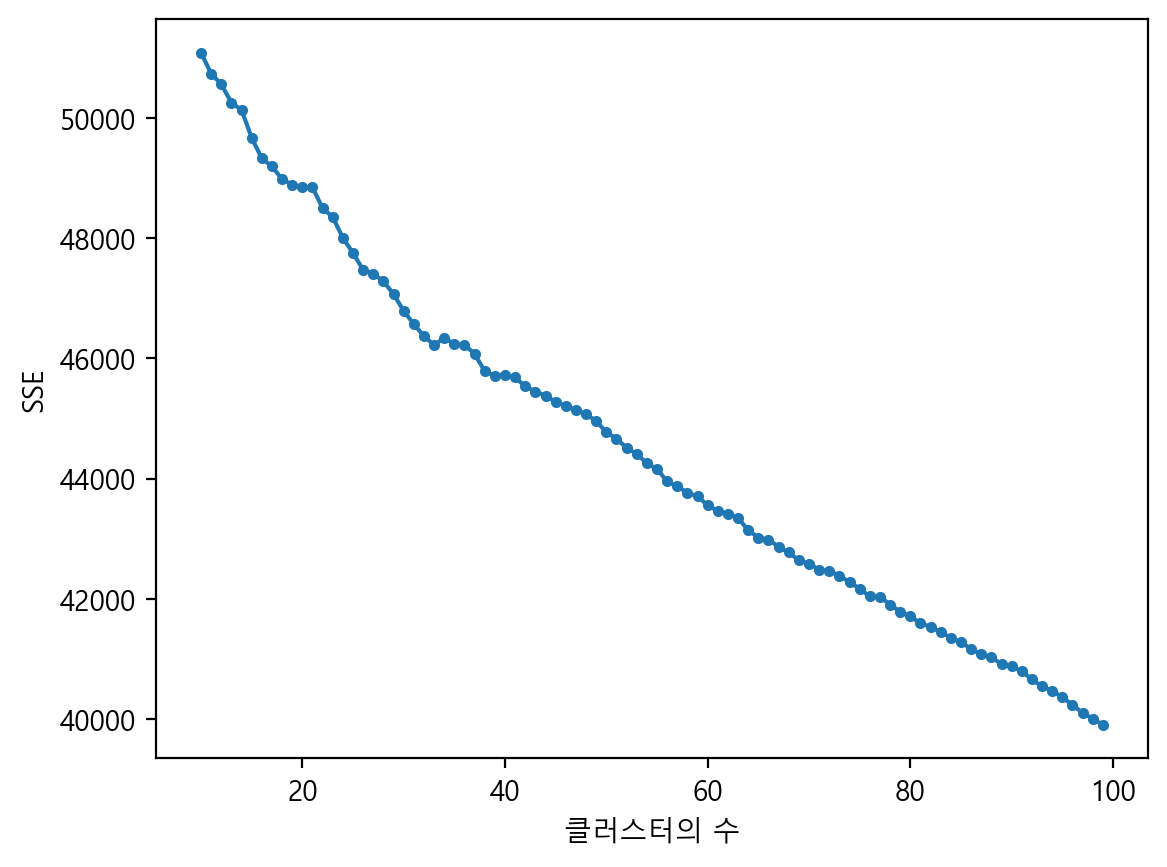

In [25]:
# 엘보우 방법을 사용하여 최적의 K값 탐색

# 1. 각 K값에 대한 SSE 값을 저장할 빈 리스트 생성
sse = []

start_num = 10
finish_num = 100

for k in range(start_num, finish_num):  # 클러스터의 개수 (K)를 start_num부터 finish_num까지 변화시키면서 SSE 값 계산
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(kobart_contexts)
    sse.append(kmeans.inertia_)         # inertia_: KMeans 모델이 계산한 SSE 값

# SSE 그래프 확인
plt.plot(range(start_num, finish_num), sse, marker='o', markersize=3)
plt.xlabel('클러스터의 수')
plt.ylabel('SSE')
plt.show()

<br><br><br><hr>

## **✅07. K-means Clustering**

In [44]:
# kmeans 클러스터링 진행
n_clusters = 3
clt = KMeans(n_clusters=n_clusters)
clt.fit(kobart_contexts)

KMeans(n_clusters=3)

In [45]:
# 중심점 간의 거리를 교차 계산
# centroids의 좌표를 담고 있는 배열 
# e.g. (클러스터의 수, 차원) == (15, 768)
kobart_centroid = clt.cluster_centers_.astype(np.int64())

# 중심점들 간의 유클리디안 거리 계산 (15, 15)
kobart_dist = cdist(kobart_centroid, kobart_centroid)
kobart_centroid.shape

(3, 768)

In [46]:
# 각 VOD 콘텐츠별로 소속 클러스터로 매핑

# 각 데이터가 어떤 클러스터에 소속되어있는지 예측
kobart_xdata = clt.predict(kobart_contexts)
# 1차원 형태의 배열을 2차원 배열로 변환 (x, 1) 형태
kobart_xdata = kobart_xdata.reshape(kobart_xdata.shape[0], 1)

kobart_xdata.shape

(1011, 1)

<br><br><br><hr>

## **✅08. 클러스터별 데이터 확인**

In [14]:
def kobart_display_cluster_image(cnum=0):
  # 해당 클러스터의 데이터 인덱스 찾기
  kobart_cluster_indices = np.where(kobart_xdata == cnum)[0]

  # 해당 클러스터에 포함된 데이터 출력
  kobart_cluster_data = drama.iloc[kobart_cluster_indices][['asset_nm_전처리']]
  print(f"\nCluster {cnum}:")
  print(kobart_cluster_data)
  print("")

  # 클러스터 벡터 추출
  kobart_cluster_embeddings = kobart_contexts[kobart_xdata.flatten() == cnum]

  # 코사인 유사도 계산
  kobart_similarities = cosine_similarity(kobart_cluster_embeddings)

  # 히트맵으로 시각화
  plt.figure(figsize=(14, 14))
  sns.heatmap(kobart_similarities,
              # annot=True,
              # fmt='.2f',
              # annot_kws={'size':8},
              cmap='Blues',
              square=True,
              linewidth=.1,
              cbar_kws={"shrink": .6})  # 컬러바 크기 줄이기
  plt.title(f"군집 {cnum}의 코사인 유사도 히트맵 시각화")
  plt.show()

ipywidgets.interact(kobart_display_cluster_image, cnum=(0, n_clusters-1, 1))
# cnum: 해당 클러스터에 포함된 영화 제목 출력

NameError: name 'ipywidgets' is not defined

<br><br><br><hr>

## **✅09. 군집별 빈도수 top20 단어 확인 및 워드클라우드 시각화**

In [48]:
from collections import Counter
from konlpy.tag import Okt
from wordcloud import WordCloud

In [59]:
# 불용어 리스트에 해지, 시청, 가능, 서비스 추가
additional_stop_words = ['해지', '시청', '가능', '서비스', '평생', '소장', '시작', '사랑', '받다', '만나다',
                         '더', '말', '다시', '사람', '사건', '곳', '없다', '그렇다', '대한', '이야기']
custom_stopwords.extend(additional_stop_words)

In [60]:
okt = Okt()

In [61]:
def kobart_display_cluster_with_adj(cnum=0):
    kobart_cluster_indices = np.where(kobart_xdata == cnum)[0]
    kobart_cluster_data = drama.iloc[kobart_cluster_indices]['summary_최신순']
    cluster_size = len(kobart_cluster_indices)
    kobart_combined_text = " ".join(kobart_cluster_data)
    
    # Okt로 명사와 형용사 추출
    kobart_pos = okt.pos(kobart_combined_text, norm=True, stem=True)  # 형태소 분석 (표준화 및 어근화)
    kobart_words = [word for word, tag in kobart_pos if tag in ['Noun', 'Adjective', 'Verb']]  # 명사와 형용사 필터링

    filtered_words = [word for word in kobart_words if word not in custom_stopwords]
    word_counts = Counter(filtered_words)
    top_words = word_counts.most_common(20)

    print(f"\nCluster {cnum}({cluster_size})의 Top 20 명사/형용사:")
    for word, count in top_words:
        print(f"{word}: {count}")

    wordcloud = WordCloud(
        font_path='../etc/D2Coding-Ver1.3.2-20180524.ttf',
        width=1000, 
        height=600, 
        background_color='white',
        colormap='Set2'
    ).generate_from_frequencies(word_counts)

    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"KoBART - Cluster {cnum}의 명사+형용사 워드클라우드 ({cluster_size})")
    plt.show()
    
# ipywidgets로 군집 선택
ipywidgets.interact(kobart_display_cluster_with_adj, cnum=(0, n_clusters - 1, 1))

interactive(children=(IntSlider(value=0, description='cnum', max=2), Output()), _dom_classes=('widget-interact…

<function __main__.kobart_display_cluster_with_adj(cnum=0)>